In [1]:
# Standard library imports
import datetime as dt
import warnings

# Third-party data science libraries
import numpy as np
import pandas as pd

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer

# Configuration
warnings.filterwarnings('ignore')

# Loading the Dataset
1. Load df from `vehicles_proccesed.csv`
2. Split into X and y
3. Train-Test split with 80/20

In [2]:
# Load the processed vehicles dataset
df = pd.read_csv('../data/vehicles_processed.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (312846, 14)
Columns: ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'type', 'paint_color', 'state']


,id,region,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,paint_color,state
0,7316814884,other_al,33590,2014.0,gmc,other_gmc,good,gas,57923.0,clean,other,pickup,white,al
1,7316814758,other_al,22590,2010.0,chevrolet,silverado 1500,good,gas,71229.0,clean,other,pickup,blue,al
2,7316814989,other_al,39590,2020.0,chevrolet,other_chevrolet,good,gas,19160.0,clean,other,pickup,red,al
3,7316743432,other_al,30990,2017.0,toyota,other_toyota,good,gas,41124.0,clean,other,pickup,red,al
4,7316356412,other_al,15000,2013.0,ford,other_ford,excellent,gas,128000.0,clean,automatic,truck,black,al


In [3]:
# Split into X and Y
# Identify categorical and numerical columns
categorical_cols = ['region', 'manufacturer', 'model', 'condition', 'fuel',  
                   'title_status', 'transmission', 'type', 'paint_color', 'state']
numerical_cols =   ['year', 'odometer']

# Prepare features and target
X = df[categorical_cols + numerical_cols]
y = df['price']

print(f"Features shape: {X.shape}")
print(f"Target shape:   {y.shape}")
print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns:   {numerical_cols}")

Features shape: (312846, 12)
Target shape:   (312846,)
Categorical columns: ['region', 'manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'type', 'paint_color', 'state']
Numerical columns:   ['year', 'odometer']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size:     {X_test.shape[0]}")

Training set size: 250276
Test set size:     62570


# Preprocessing pipeline
- Create `age` based on year by subtracting current year
- Polynomials degree=2: `age²` and `odometer²`
- Interaction term between `age` and `odometer`
- One-hot encoding for categorical variables

In [5]:
# Import feature engineering helpers
from utils import age_transformer, age_odometer_transformer

# Create preprocessing pipelines
age_pipeline = Pipeline([
    ('to_age',  age_transformer),                                    # year → age
    ('poly',    PolynomialFeatures(degree=2, include_bias=False)),   # add age²
    ('scaler',  StandardScaler())                                    # scale age, age²
])

odometer_pipeline = Pipeline([
    ('poly',    PolynomialFeatures(degree=2, include_bias=False)),   # add odo²
    ('scaler',  StandardScaler())                                    # scale odo, odo²
])

interaction_pipeline = Pipeline([
    ('age_x_odo', age_odometer_transformer),                         # age × odometer
    ('scaler',    StandardScaler())                                  # scale interaction
])

# Create the main preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',      OneHotEncoder(drop='first',
                                   sparse_output=False,
                                   handle_unknown='ignore'),
                     categorical_cols),
        ('age',      age_pipeline,        ['year']),                 # year → age, age²
        ('odometer', odometer_pipeline,   ['odometer']),             # odo, odo²
        ('ageXodo',  interaction_pipeline, ['year', 'odometer'])     # age×odo
    ],
    remainder='drop',
    verbose_feature_names_out=False                                  # cleaner column names
)

# Testing 2 models
1. RidgeCV
2. SelectFromModel using Lasso -> Ridge

In [6]:
# Use a smaller subset for hyperparameter tuning to speed up the process
sample_size = 10000 # around 4% of the training set
X_train_sample = X_train.sample(n=sample_size, random_state=42)
y_train_sample = y_train[X_train_sample.index]

### 1. RidgeCV

In [7]:
ridge_cv = RidgeCV(
    alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 
    scoring='neg_mean_squared_error',
    cv=5,
)

pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ridge_cv)
])

pipeline1

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('age', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [8]:
# Fit the pipeline and get results
pipeline1.fit(X_train_sample, y_train_sample)

print("Training completed successfully!")
print(f"Best alpha selected by RidgeCV: {pipeline1.named_steps['model'].alpha_}")

# Make test predictions to verify it works
y_sample_pred = pipeline1.predict(X_train_sample)
sample_rmse = np.sqrt(mean_squared_error(y_train_sample, y_sample_pred))
print(f"Sample RMSE: ${sample_rmse:,.2f}")

Training completed successfully!
Best alpha selected by RidgeCV: 1.0
Sample RMSE: $7,084.77


### 2. Lasso selector with Ridge

In [9]:
# Create a base pipeline (we'll tune the alpha parameters)
pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(Lasso(random_state=42))),
    ('model', Ridge(random_state=42))
])

pipeline2

,steps,"[('preprocessor', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('age', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [10]:
# Import training helper
from utils import fit_gridsearch_pipeline

# Define parameter grid for GridSearchCV
param_grid = {
    'selector__estimator__alpha': np.logspace(-2, 2, 5),    # 0.01 … 100
    'model__alpha': np.logspace(-2, 3, 6)                   # 0.01 … 1_000
}

# Fit pipeline with GridSearchCV (use verbose=True for detailed output)
grid_search = fit_gridsearch_pipeline(
    pipeline=pipeline2,
    param_grid=param_grid, 
    X_train=X_train_sample,
    y_train=y_train_sample,
    cv=3,
    verbose=False  # Set to True for detailed output
)

Training completed successfully!
Best Model Alpha selected by GridSearchCV: 1.0
Best Selector Estimator Alpha selected by GridSearchCV: 1.0
Sample RMSE: $7,085.56


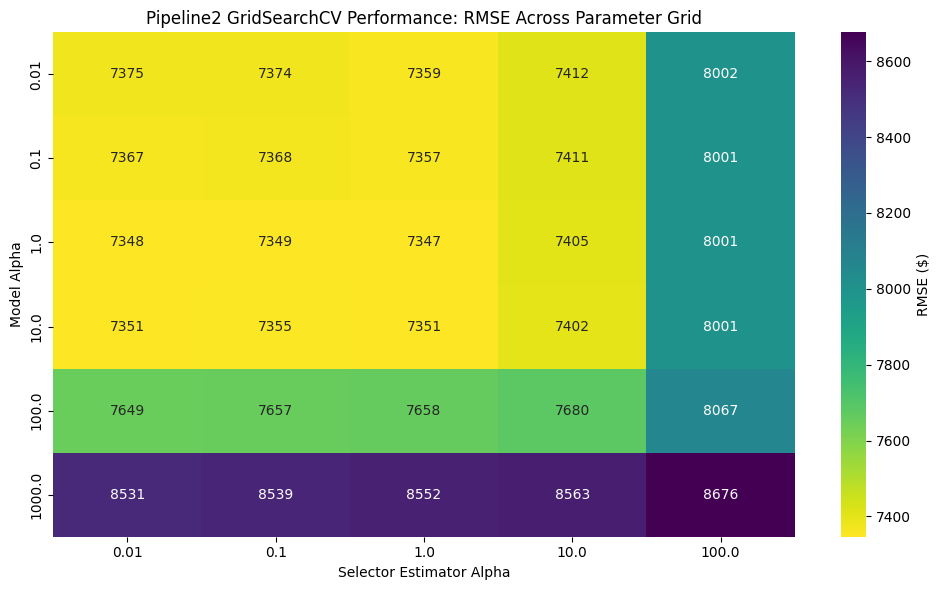


Best parameter combination:
  Model Alpha: 1.0
  Selector Estimator Alpha: 1.0
  Best CV RMSE: $7,346.58

Performance range:
  Best RMSE: $7,346.58
  Worst RMSE: $8,676.21
  Improvement: $1,329.63 (15.3%)


In [11]:
# Import and use the visualization function from utils
from utils import visualize_gridsearch_results

# Create comprehensive visualization and analysis of GridSearchCV results
performance_stats = visualize_gridsearch_results(
    grid_search,
    title="Pipeline2 GridSearchCV Performance",
    figsize=(10, 6)
)

# Model comparison against Holdout

In [ ]:
## Training final models on full training data

print("Training Pipeline 1 (RidgeCV) on full training data...")
# Create fresh Pipeline 1 with best alpha from RidgeCV
final_pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0, random_state=42))  # Use best alpha found by RidgeCV
])

# Fit on full training data
final_pipeline1.fit(X_train, y_train)
print("✓ Pipeline 1 training completed")

print("\nTraining Pipeline 2 (Lasso Selector + Ridge) on full training data...")
# Create fresh Pipeline 2 with best hyperparameters from GridSearchCV
final_pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(Lasso(alpha=1.0, random_state=42))),  # Best selector alpha
    ('model', Ridge(alpha=1.0, random_state=42))  # Best model alpha
])

# Fit on full training data
final_pipeline2.fit(X_train, y_train)
print("✓ Pipeline 2 training completed")

print(f"\nTraining completed on {X_train.shape[0]:,} samples")
print(f"Ready for evaluation on {X_test.shape[0]:,} holdout samples")


In [ ]:
## Holdout Test Set Evaluation

print("Evaluating models on holdout test set...\n")

# Make predictions on test set
y_pred1 = final_pipeline1.predict(X_test)
y_pred2 = final_pipeline2.predict(X_test)

# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

# Calculate metrics for both models
metrics1 = calculate_metrics(y_test, y_pred1, "Pipeline 1 (Ridge)")
metrics2 = calculate_metrics(y_test, y_pred2, "Pipeline 2 (Lasso→Ridge)")

# Display results
results_df = pd.DataFrame([metrics1, metrics2])
print("📊 HOLDOUT TEST SET PERFORMANCE")
print("=" * 50)
print(f"{'Model':<25} {'RMSE':<12} {'MAE':<12} {'R²':<8}")
print("-" * 50)
for _, row in results_df.iterrows():
    print(f"{row['Model']:<25} ${row['RMSE']:<11,.0f} ${row['MAE']:<11,.0f} {row['R²']:<8.4f}")

print("\n🏆 MODEL COMPARISON")
print("=" * 30)
rmse_diff = metrics1['RMSE'] - metrics2['RMSE']
mae_diff = metrics1['MAE'] - metrics2['MAE']
r2_diff = metrics2['R²'] - metrics1['R²']  # Higher R² is better

if rmse_diff > 0:
    winner = "Pipeline 2"
    rmse_improvement = f"${rmse_diff:,.0f} better RMSE"
else:
    winner = "Pipeline 1"
    rmse_improvement = f"${abs(rmse_diff):,.0f} better RMSE"

print(f"Best RMSE: {winner} ({rmse_improvement})")
print(f"MAE difference: ${mae_diff:+,.0f} (Pipeline 1 vs Pipeline 2)")
print(f"R² difference: {r2_diff:+.4f} (Pipeline 2 vs Pipeline 1)")

# Additional insights
print(f"\n📈 PERFORMANCE INSIGHTS")
print("=" * 30)
avg_price = y_test.mean()
print(f"Average test set price: ${avg_price:,.0f}")
print(f"Pipeline 1 RMSE as % of avg price: {(metrics1['RMSE']/avg_price)*100:.2f}%")
print(f"Pipeline 2 RMSE as % of avg price: {(metrics2['RMSE']/avg_price)*100:.2f}%")

# Check if feature selection made a difference
n_features_original = final_pipeline1.named_steps['preprocessor'].transform(X_test[:1]).shape[1]
n_features_selected = final_pipeline2.named_steps['selector'].transform(
    final_pipeline2.named_steps['preprocessor'].transform(X_test[:1])
).shape[1]

print(f"\n🔍 FEATURE SELECTION ANALYSIS")
print("=" * 35)
print(f"Original features: {n_features_original:,}")
print(f"Selected features: {n_features_selected:,}")
print(f"Features removed: {n_features_original - n_features_selected:,} ({((n_features_original - n_features_selected)/n_features_original)*100:.1f}%)")

results_df


In [ ]:
## Visual Performance Comparison

import matplotlib.pyplot as plt

# Create performance comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison on Holdout Test Set', fontsize=16, fontweight='bold')

# 1. RMSE and MAE comparison
metrics_comparison = ['RMSE', 'MAE']
pipeline1_metrics = [metrics1['RMSE'], metrics1['MAE']]
pipeline2_metrics = [metrics2['RMSE'], metrics2['MAE']]

x = np.arange(len(metrics_comparison))
width = 0.35

bars1 = ax1.bar(x - width/2, pipeline1_metrics, width, label='Pipeline 1 (Ridge)', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x + width/2, pipeline2_metrics, width, label='Pipeline 2 (Lasso→Ridge)', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Dollar Amount ($)')
ax1.set_title('RMSE and MAE Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_comparison)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'${height:,.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'${height:,.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# 2. R² comparison
models = ['Pipeline 1\n(Ridge)', 'Pipeline 2\n(Lasso→Ridge)']
r2_scores = [metrics1['R²'], metrics2['R²']]
colors = ['skyblue', 'lightcoral']

bars = ax2.bar(models, r2_scores, color=colors, alpha=0.8)
ax2.set_ylabel('R² Score')
ax2.set_title('R² Score Comparison')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

# Add value labels
for bar, score in zip(bars, r2_scores):
    ax2.annotate(f'{score:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Residuals distribution comparison
residuals1 = y_test - y_pred1
residuals2 = y_test - y_pred2

ax3.hist(residuals1, bins=50, alpha=0.7, label='Pipeline 1 (Ridge)', color='skyblue', density=True)
ax3.hist(residuals2, bins=50, alpha=0.7, label='Pipeline 2 (Lasso→Ridge)', color='lightcoral', density=True)
ax3.set_xlabel('Residuals ($)')
ax3.set_ylabel('Density')
ax3.set_title('Residuals Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Predicted vs Actual scatter plot comparison
sample_size_plot = min(1000, len(y_test))  # Sample for cleaner visualization
idx_sample = np.random.choice(len(y_test), sample_size_plot, replace=False)

ax4.scatter(y_test.iloc[idx_sample], y_pred1[idx_sample], alpha=0.5, s=20, 
           label='Pipeline 1 (Ridge)', color='skyblue')
ax4.scatter(y_test.iloc[idx_sample], y_pred2[idx_sample], alpha=0.5, s=20, 
           label='Pipeline 2 (Lasso→Ridge)', color='lightcoral')

# Perfect prediction line
min_val = min(y_test.min(), min(y_pred1.min(), y_pred2.min()))
max_val = max(y_test.max(), max(y_pred1.max(), y_pred2.max()))
ax4.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Prediction')

ax4.set_xlabel('Actual Price ($)')
ax4.set_ylabel('Predicted Price ($)')
ax4.set_title(f'Predicted vs Actual (Sample of {sample_size_plot:,} points)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics for residuals
print(f"\n📈 RESIDUALS ANALYSIS")
print("=" * 30)
print(f"Pipeline 1 (Ridge):")
print(f"  Mean residual: ${residuals1.mean():,.2f}")
print(f"  Std residual:  ${residuals1.std():,.2f}")
print(f"  95% within:    ±${1.96 * residuals1.std():,.2f}")

print(f"\nPipeline 2 (Lasso→Ridge):")
print(f"  Mean residual: ${residuals2.mean():,.2f}")
print(f"  Std residual:  ${residuals2.std():,.2f}")
print(f"  95% within:    ±${1.96 * residuals2.std():,.2f}")
